In [13]:
import cv2
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
import json
from ultralytics import YOLO

In [39]:
def resize_bottle(image_path, model_path, expand_dims=False, confidence_threshold=0.5, target_size=224):

    # Load image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not read {image_path}. Halting.")
        return None

    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Load YOLO model
    model = YOLO(model_path)

    # Perform inference
    results = model.predict(source=image, conf=confidence_threshold, verbose=False)
    detections = results[0]
    
    # Check if any detections were found
    if detections.boxes is None or len(detections.boxes) == 0:
        print(f"No bottles detected in {image_path}. Skipping.")
        return None  # Skip processing for this image

    # Get bounding box of the first detected object
    box = detections.boxes[0].xyxy[0].cpu().numpy()  # [x_min, y_min, x_max, y_max]
    x_min, y_min, x_max, y_max = map(int, box)

    # Calculate width and height of the bounding box
    box_width = x_max - x_min
    box_height = y_max - y_min

    # Calculate the center of the bounding box
    center_x = x_min + box_width // 2
    center_y = y_min + box_height // 2

    # Calculate the side length of the square crop
    crop_size = max(box_width, box_height, target_size)

    # Determine the square crop boundaries
    crop_x_min = max(0, center_x - crop_size // 2)
    crop_y_min = max(0, center_y - crop_size // 2)
    crop_x_max = crop_x_min + crop_size
    crop_y_max = crop_y_min + crop_size

    # Adjust crop to ensure it fits within the image boundaries
    if crop_x_max > image.shape[1]:
        crop_x_min -= (crop_x_max - image.shape[1])
        crop_x_max = image.shape[1]
    if crop_y_max > image.shape[0]:
        crop_y_min -= (crop_y_max - image.shape[0])
        crop_y_max = image.shape[0]

    # Ensure the adjustments keep the crop within valid bounds
    crop_x_min = max(0, crop_x_min)
    crop_y_min = max(0, crop_y_min)

    # Perform cropping
    cropped_bottle = image[crop_y_min:crop_y_max, crop_x_min:crop_x_max]

    # Resize the cropped image to the target size (224x224)
    resized_bottle = cv2.resize(cropped_bottle, (target_size, target_size), interpolation=cv2.INTER_AREA)

    if expand_dims:
        resize_bottle = np.expand_dims(resized_bottle, axis=0)  

    return resized_bottle

In [40]:
images_dir = "test_images"
labels_dir = "test_labels"

def center_crop_and_resize(image_path, expand_dims=False, target_size=(224, 224)):
    """
    Crops the center square of an image and resizes it to the target size.

    Args:
        image_path (str): Path to the input image.
        target_size (tuple): Target size for resizing (width, height).

    Returns:
        PIL.Image.Image: The cropped and resized image.
    """

    image = Image.open(image_path)
    width, height = image.size

    # Calculate the cropping box for a center square
    min_dim = min(width, height)
    left = (width - min_dim) // 2
    top = (height - min_dim) // 2
    right = left + min_dim
    bottom = top + min_dim

    # Crop the center square
    image = image.crop((left, top, right, bottom))

    # Resize to the target size
    image = image.resize(target_size, Image.Resampling.LANCZOS)

    # image = np.expand_dims(image, axis=0) # Add batch dimension

    return image 

# Load dataset
def load_dataset(images_dir, labels_dir):
    images = []
    labels = []
    for image_file in os.listdir(images_dir):
        if image_file.endswith(".jpg"):
            image_path = os.path.join(images_dir, image_file)
            label_path = os.path.join(labels_dir, image_file.replace(".jpg", ".json"))

            # Load and preprocess image
            image = resize_bottle(image_path, "yolo.pt")  # Resize for ResNet50
            if image is not None:
                images.append(np.array(image) / 255.0)  # Normalize to [0, 1]

                # Load label
                with open(label_path, 'r') as f:
                    label = json.load(f)
                    labels.append([label["red_count"], label["green_count"], label["blue_count"]])

    return np.array(images), np.array(labels)

images, labels = load_dataset(images_dir, labels_dir)

print(images.shape)

(6, 224, 224, 3)


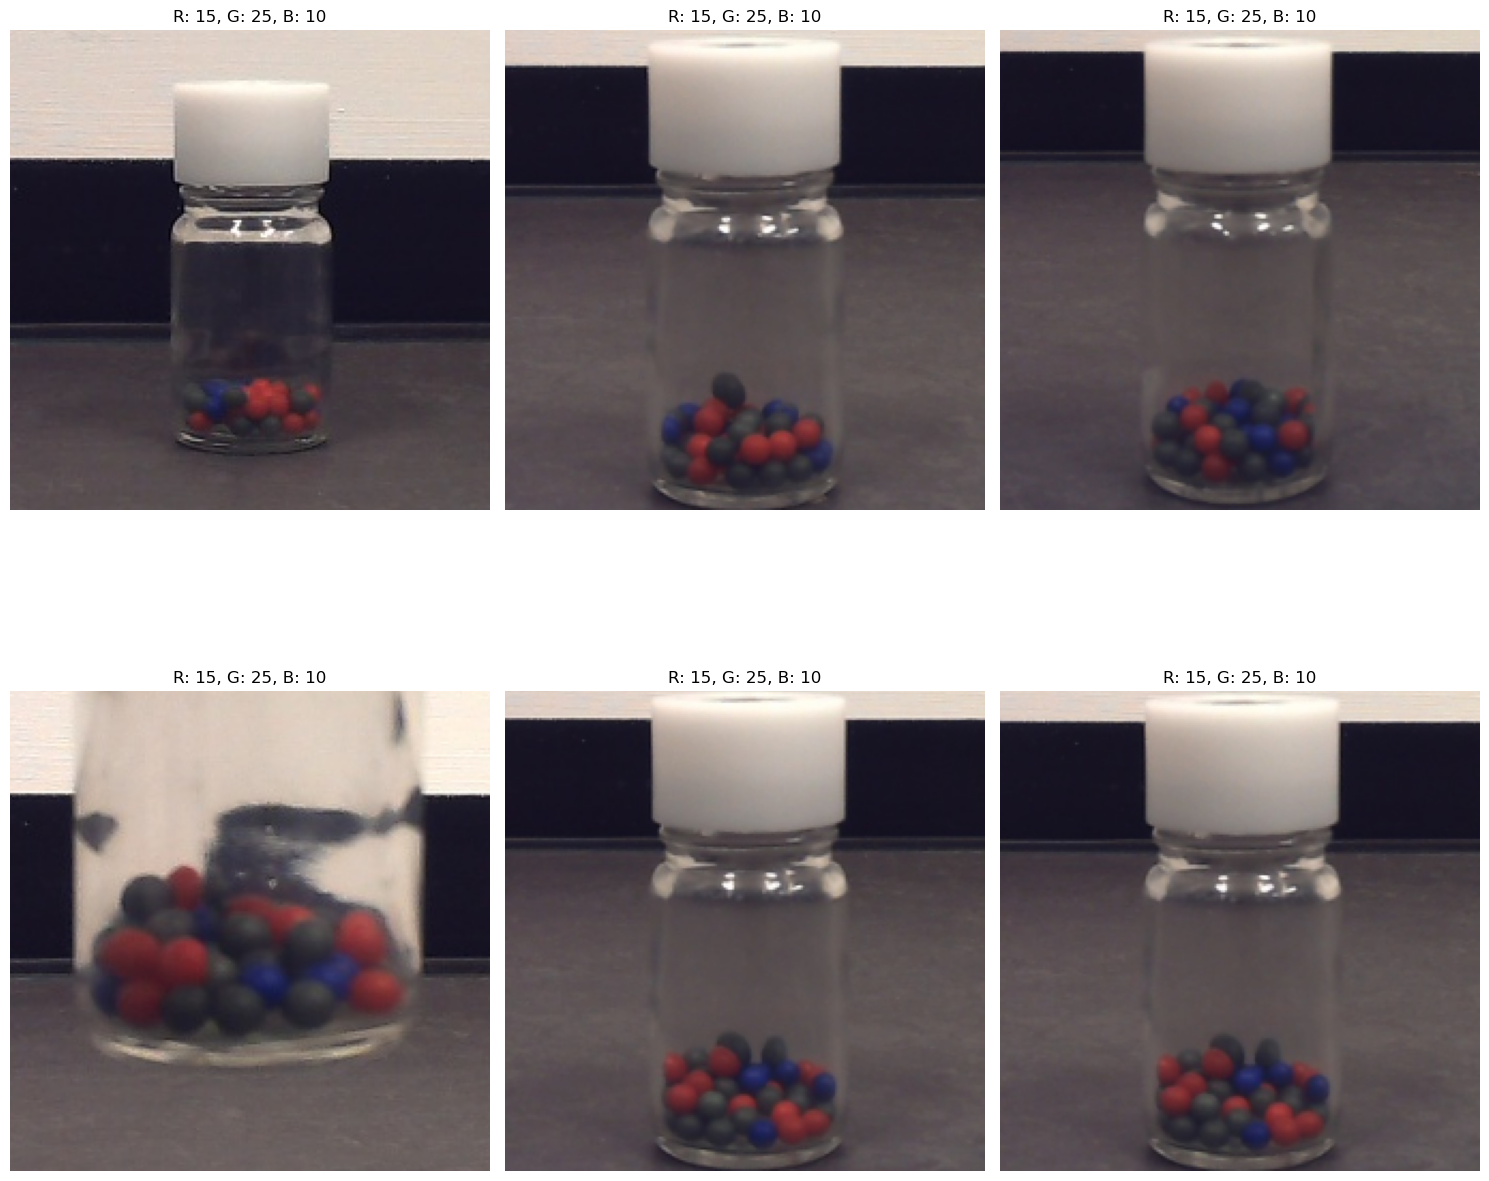

In [41]:
# Create a 5x5 grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))

# Flatten the axes for easier iteration
axs = axs.flatten()

# Plot the first 25 images and their labels
for idx, (image, label) in enumerate(zip(images, labels)):
    axs[idx].imshow(image)
    axs[idx].set_title(f"R: {label[0]}, G: {label[1]}, B: {label[2]}")
    axs[idx].axis("off")  # Remove axes for clarity

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [58]:
model = tf.keras.models.load_model('models/resnet50_model_v12.keras')
print("Model loaded...")

Model loaded...


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
[[     10.312        17.9      20.967]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[     10.122      17.848      12.951]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[[      8.513      21.721       17.88]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[[     21.982      35.215      26.009]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[     11.883      23.069      13.004]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[[      11.46      23.371      12.866]]


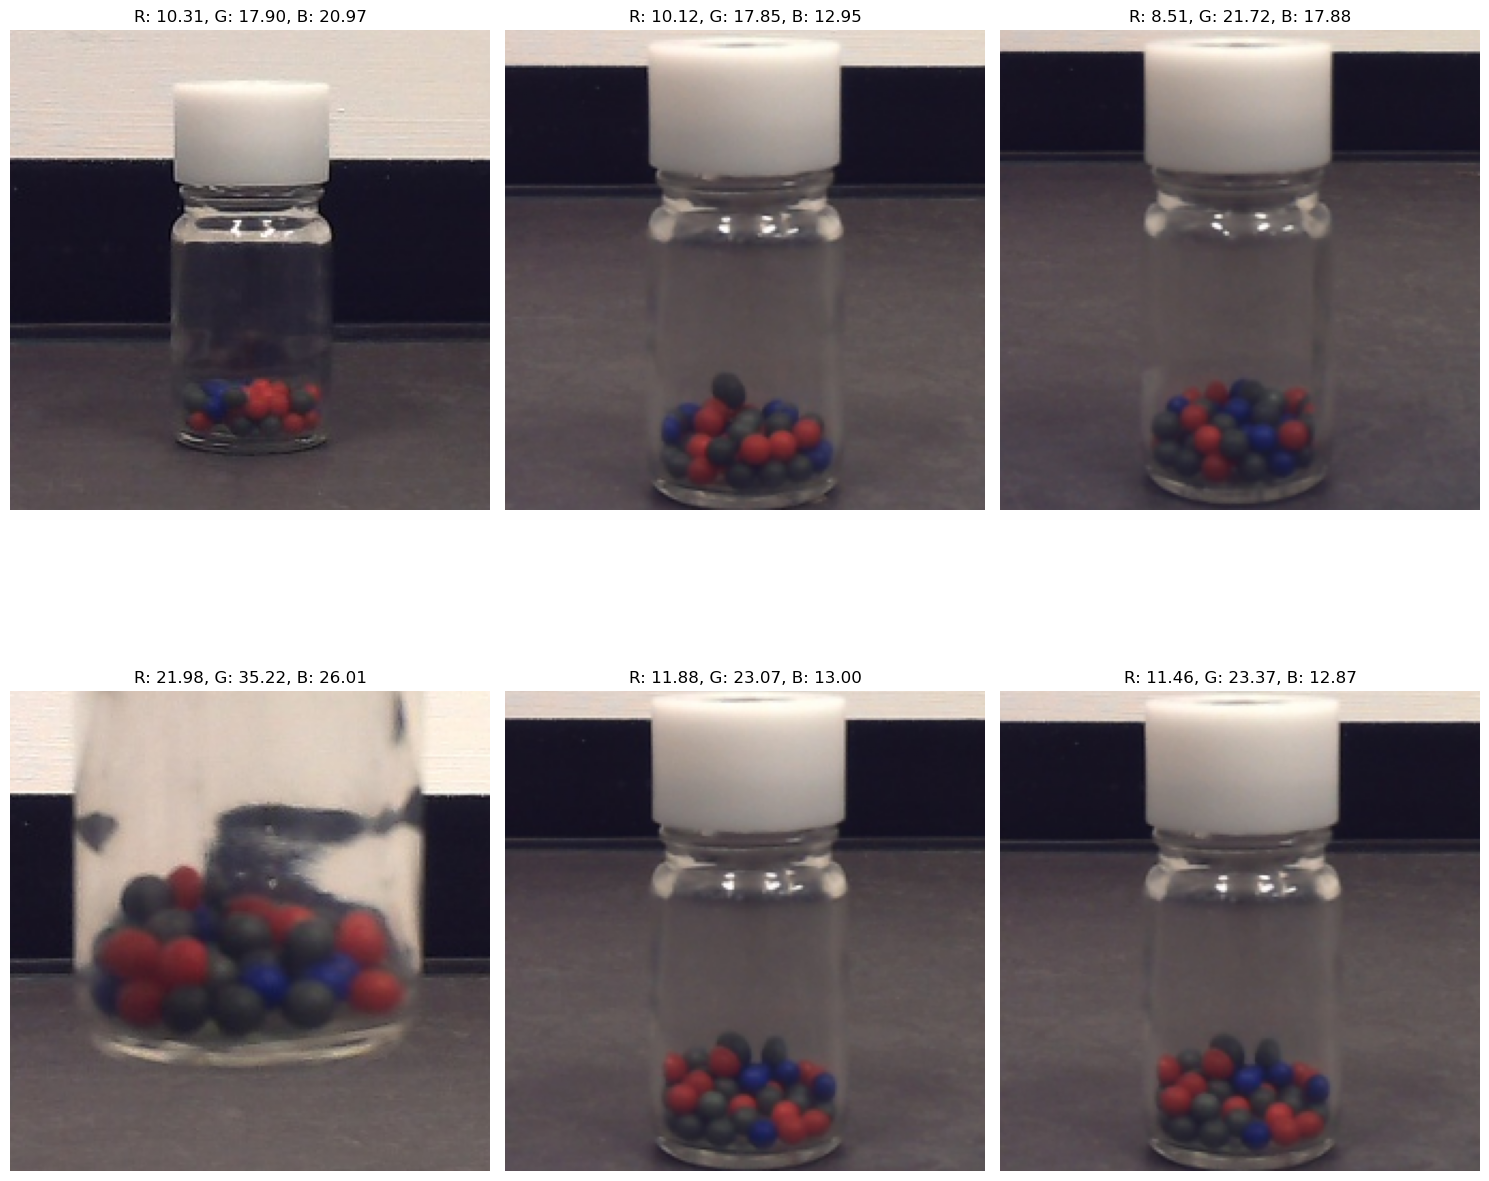

In [59]:
predictions = []

for img in images:
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)
    print(prediction)
    predictions.append((img, prediction[0]))

# Create a 5x5 grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))

# Flatten the axes for easier iteration
axs = axs.flatten()

# Plot the first 25 images and their labels
for idx, (image, prediction) in enumerate(predictions):
    axs[idx].imshow(image[0])
    axs[idx].set_title(f"R: {prediction[0]:.2f}, G: {prediction[1]:.2f}, B: {prediction[2]:.2f}")    
    axs[idx].axis("off")  # Remove axes for clarity

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [ ]:
# Paths
images_dir = "cropped_images"
labels_dir = "labels"

def center_crop_and_resize(image_path, target_size=(224, 224)):
    """
    Crops the center square of an image and resizes it to the target size.

    Args:
        image_path (str): Path to the input image.
        target_size (tuple): Target size for resizing (width, height).

    Returns:
        PIL.Image.Image: The cropped and resized image.
    """

    image = Image.open(image_path)
    width, height = image.size

    # Calculate the cropping box for a center square
    min_dim = min(width, height)
    left = (width - min_dim) // 2
    top = (height - min_dim) // 2
    right = left + min_dim
    bottom = top + min_dim

    # Crop the center square
    image = image.crop((left, top, right, bottom))

    # Resize to the target size
    image = image.resize(target_size, Image.Resampling.LANCZOS)

    return image

# Load dataset
def load_dataset(images_dir, labels_dir):
    images = []
    labels = []
    for image_file in os.listdir(images_dir):
        if image_file.endswith(".jpg"):
            image_path = os.path.join(images_dir, image_file)
            label_path = os.path.join(labels_dir, image_file.replace(".jpg", ".json"))

            # Load and preprocess image
            image = center_crop_and_resize(image_path, target_size=(224, 224))  # Resize for ResNet50
            images.append(np.array(image) / 255.0)  # Normalize to [0, 1]

            # Load label
            with open(label_path, 'r') as f:
                label = json.load(f)
                labels.append([label["red_count"], label["green_count"], label["blue_count"]])

    return np.array(images), np.array(labels)

images, labels = load_dataset(images_dir, labels_dir)
